In [1]:
import itertools as itt
import math
from collections import Counter, defaultdict

import bioregistry
import bioversions
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pyobo
import seaborn as sns
from disease import CONFIGURATION, MODULE
from IPython.display import SVG
from pyobo.sources.mesh import get_mesh_category_curies
from tqdm.auto import tqdm

import semra
import semra.api
from semra.api import get_index, to_multidigraph
from semra.io import from_pickle, from_sssom

/Users/cthoyt/.virtualenvs/indra/lib/python3.11/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


## Summarize the Resources

In [2]:
# some resources are generic, so we want to cut to a relevant subset
subsets = {
    "mesh": [*get_mesh_category_curies("C"), *get_mesh_category_curies("F")],
    "efo": ["efo:0000408"],
    "ncit": ["ncit:C2991"],
}

terms = {}
for prefix in CONFIGURATION.priority:
    id_name_mapping = pyobo.get_id_name_mapping(prefix)
    subset = {
        descendant
        for parent_curie in subsets.get(prefix, [])
        for descendant in pyobo.get_descendants(parent_curie) or []
    }
    if subset:
        terms[prefix] = {k: v for k, v in id_name_mapping.items() if f"{prefix}:{k}" in subset}
    else:
        terms[prefix] = id_name_mapping

doid 11511
mondo 24099
efo 16410
mesh 354069
ncit 181982
orphanet 0
orphanet.ordo 0
omim 0
omim.ps 0
gard 0
icd10 2345
icd10cm 0
icd10pcs 0
icd11 69477
icd9 0
icd9cm 0


[icdo vNone] could not load: Command '['java', '-jar', '/Users/cthoyt/.data/robot/robot.jar', 'merge', '-i', '/Users/cthoyt/.data/pyobo/raw/icdo/icdo.owl', 'convert', '-o', '/Users/cthoyt/.data/pyobo/raw/icdo/icdo.obo']' returned non-zero exit status 1.
Traceback (most recent call last):
  File "/Users/cthoyt/dev/pyobo/src/pyobo/api/names.py", line 142, in get_id_name_mapping
    return _get_id_name_mapping()
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cthoyt/dev/pystow/src/pystow/cache.py", line 83, in _wrapped
    rv = func()
         ^^^^^^
  File "/Users/cthoyt/dev/pyobo/src/pyobo/api/names.py", line 138, in _get_id_name_mapping
    ontology = get_ontology(prefix, force=force, strict=strict, version=version)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cthoyt/dev/pyobo/src/pyobo/identifier_utils.py", line 115, in _wrapped
    return f(norm_prefix, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cthoy

icdo 0


In [3]:
no_versions = {"icd9", "icd10cm", "icd10pcs", "icd9cm", "icdo", "gard", "omim", "orphanet", "omim.ps"}
summary_rows = [
    (
        prefix,
        bioregistry.get_license(prefix),
        bioversions.get_version(prefix) if prefix not in no_versions else None,
        len(terms.get(prefix, [])),
    )
    for prefix in CONFIGURATION.priority
]
summary_df = pd.DataFrame(summary_rows, columns=["prefix", "license", "version", "terms"])
summary_df

,prefix,license,version,terms
0,doid,CC0-1.0,2024-02-28,11511
1,mondo,CC-BY-4.0,2024-03-04,24099
2,efo,Apache-2.0,3.64.0,2082
3,mesh,CC0-1.0,2024,3120
4,ncit,CC-BY-4.0,24.02d,20094
5,orphanet,None,None,0
6,orphanet.ordo,CC-BY-4.0,4.4,0
7,omim,None,None,0
8,omim.ps,None,None,0
9,gard,None,None,0


## Summarize the Mappings

In [4]:
mappings = from_pickle(MODULE.join(name="processed.pkl"))
processed_n = len(mappings)
processed_n

413647

In [5]:
# Remove many-to-many mappings since it overinflates
# mappings = semra.api.filter_many_to_many(mappings, progress=False)
# filtered_n = len(mappings)
# filtered_n

# TODO filter out many-to-many mappings before starting -
# using the typical function doesn't work since there is

In [6]:
index = get_index(mappings, progress=False)

In [7]:
directed = defaultdict(set)
for s, p, o in index:
    if p != semra.EXACT_MATCH:
        continue
    directed[s.prefix, o.prefix].add(s.identifier)
    directed[o.prefix, s.prefix].add(o.identifier)

### Asymmetric Summarization

The following summary looks for each ordered pair of resources, what percentage of each resources' terms are mapped to the other resource. Because each resource is a different size, this is an asymmetric measurement.

The way to read this table is the horizontal index corresponds to the source prefix and the columns correspond to the target prefix. This means in the row with label "efo" and column with label "mesh" that has 14% means that 14% of EFO can be mapped to MeSH.

In [8]:
def _df(xx, default=1.0):
    rows = [
        [default if p1 == p2 else xx.get((p1, p2), None) for p2 in CONFIGURATION.priority]
        for p1 in CONFIGURATION.priority
    ]
    df = pd.DataFrame(rows, columns=CONFIGURATION.priority, index=CONFIGURATION.priority)
    df.index.name = "source_prefix"
    df.columns.name = "target_prefix"
    return df

In [9]:
asymmetric_counts = {}
for (l, r), l_entities in directed.items():
    l_terms = terms.get(l)
    if l_terms:
        count = len(l_entities.intersection(l_terms))
    else:
        count = len(l_entities)
    asymmetric_counts[l, r] = count

asymmetric_counts_summary_df = _df(asymmetric_counts, default=0).fillna(0).astype(int)
asymmetric_counts_summary_df

target_prefix,doid,mondo,efo,mesh,ncit,orphanet,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd10pcs,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,,,
doid,0,11196,2278,1863,4963,0,2508,185,81,30,11,127,0,0,0,5,1
mondo,11365,0,3248,8159,7460,0,8156,9486,575,2,15,1141,0,0,0,2,0
efo,1266,1656,0,1178,1280,0,219,117,26,0,9,296,0,0,0,0,0
mesh,262,853,587,0,462,0,138,19,2,0,3,215,0,0,0,0,0
ncit,5094,7145,2375,1585,0,0,585,217,52,2,9,529,0,0,0,1,0
orphanet,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
orphanet.ordo,2489,9545,387,612,572,0,0,33,71,1,0,193,0,0,0,1,0
omim,191,9744,216,1288,208,0,32,0,4,2,1,49,0,0,0,1,0
omim.ps,78,577,45,47,50,0,64,4,0,1,0,19,0,0,0,1,0


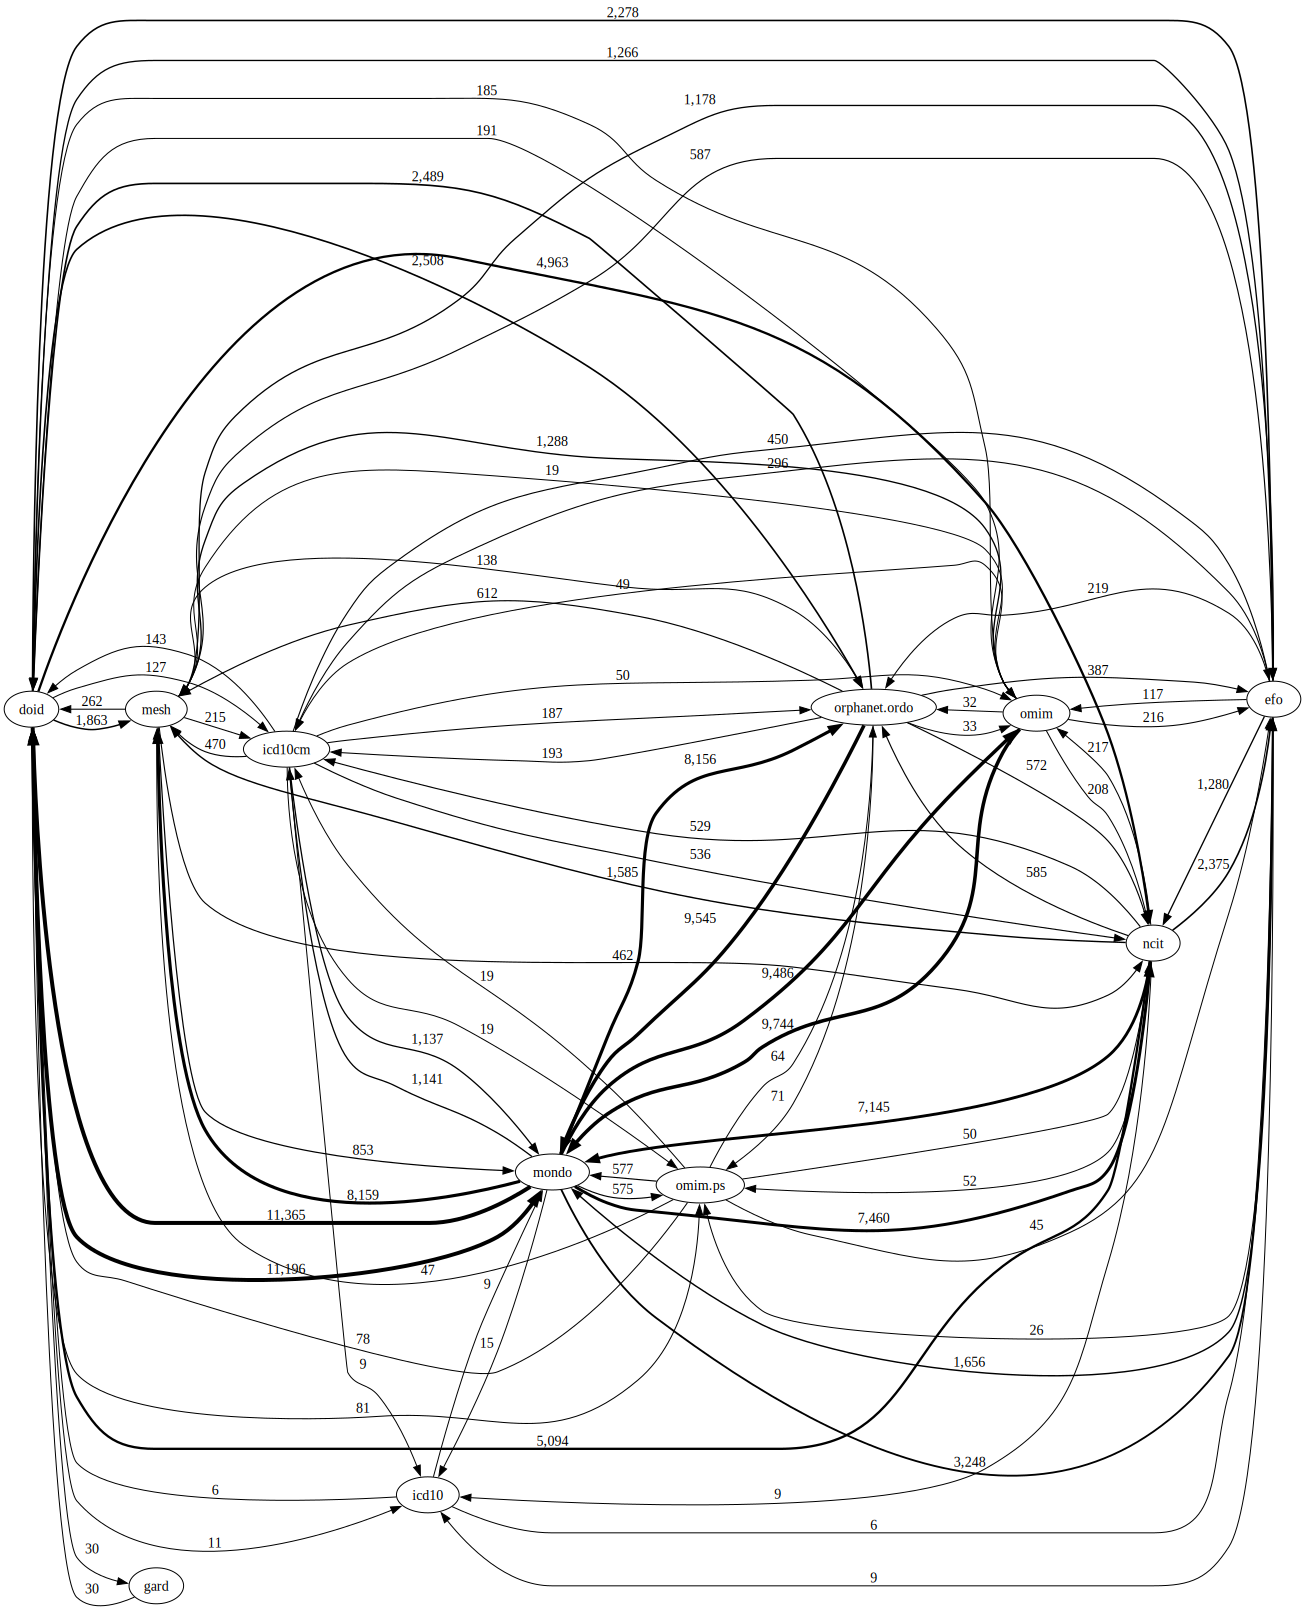

In [10]:
def _graph_svg(counter, scaling_factor: float = 3.0, fmt=",", cls=nx.DiGraph, cutoff=0.0):
    graph = cls()
    for (s, t), count in counter.items():
        if not count:
            continue
        if count <= cutoff:
            continue
        graph.add_edge(s, t, label=f"{count:{fmt}}")

    agraph = nx.nx_agraph.to_agraph(graph)
    agraph.graph_attr["rankdir"] = "LR"

    values = [v for v in counter.values() if v is not None and v > 0]
    bottom, top = min(values), max(values)
    rr = top - bottom

    for edge, weight in counter.items():
        if not weight:
            continue
        x = 1 + scaling_factor * (weight - bottom) / rr
        if agraph.has_edge(*edge):
            agraph.get_edge(*edge).attr["penwidth"] = x
    return agraph.draw(prog="dot", format="svg")


SVG(_graph_svg(asymmetric_counts, cutoff=5))

In [11]:
asymmetric = {}
for (l, r), count in asymmetric_counts.items():
    denominator = len(terms.get(l, []))
    asymmetric[l, r] = count / denominator if denominator > 0 else None

asymmetric_summary_df = _df(asymmetric)
(asymmetric_summary_df * 100).round(2)

target_prefix,doid,mondo,efo,mesh,ncit,orphanet,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd10pcs,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,,,
doid,100.00,97.26,19.79,16.18,43.12,NaN,21.79,1.61,0.70,0.26,0.10,1.10,NaN,NaN,NaN,0.04,0.01
mondo,47.16,100.00,13.48,33.86,30.96,NaN,33.84,39.36,2.39,0.01,0.06,4.73,NaN,NaN,NaN,0.01,NaN
efo,60.81,79.54,100.00,56.58,61.48,NaN,10.52,5.62,1.25,NaN,0.43,14.22,NaN,NaN,NaN,NaN,NaN
mesh,8.40,27.34,18.81,100.00,14.81,NaN,4.42,0.61,0.06,0.00,0.10,6.89,NaN,NaN,NaN,0.00,NaN
ncit,25.35,35.56,11.82,7.89,100.00,NaN,2.91,1.08,0.26,0.01,0.04,2.63,NaN,NaN,NaN,0.00,NaN
orphanet,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orphanet.ordo,NaN,NaN,NaN,NaN,NaN,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
omim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
omim.ps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


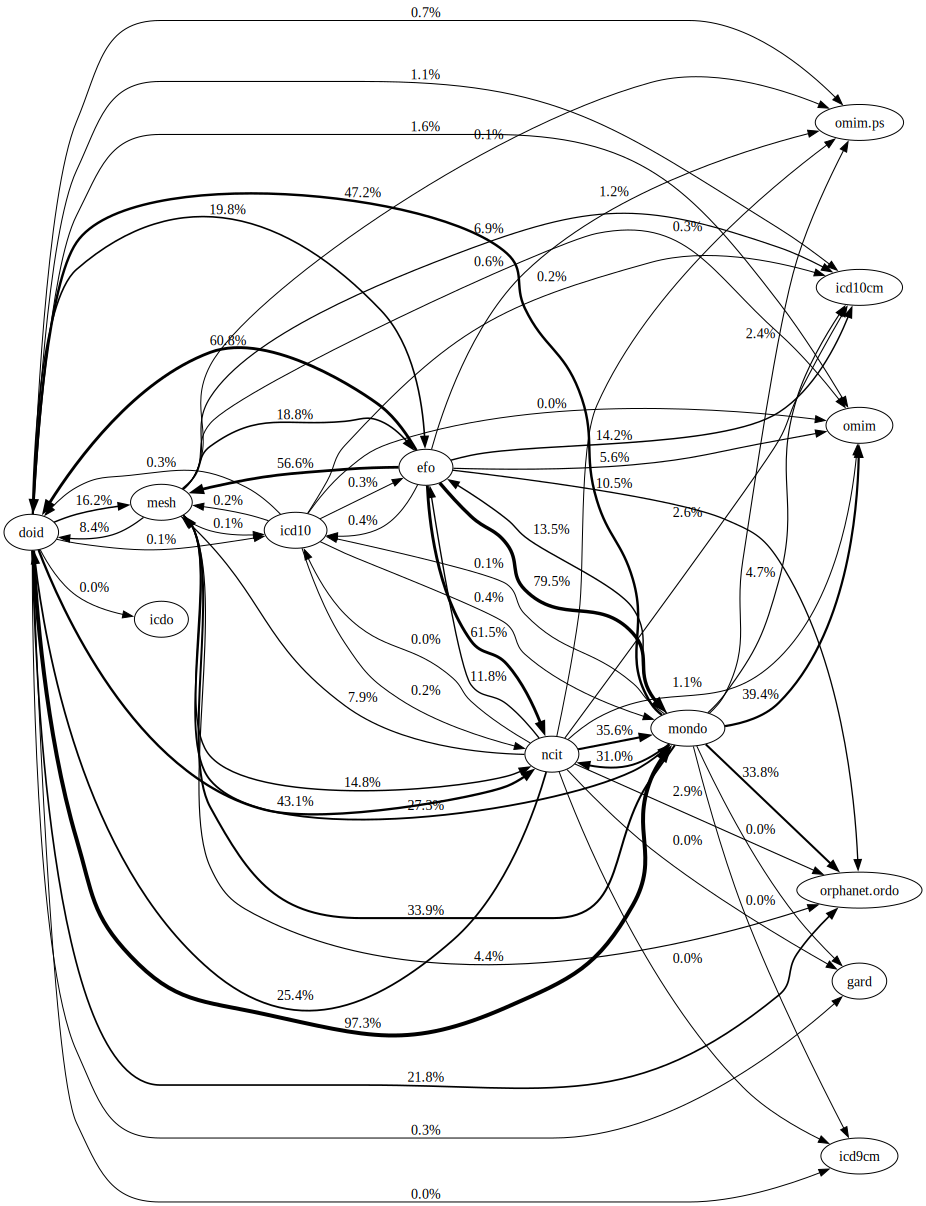

In [12]:
SVG(_graph_svg(asymmetric, fmt=".1%"))

### Symmetric Summarization

In [13]:
symmetric_counts = {}
for l, r in directed:
    left = directed[l, r]
    if left_terms := terms.get(l, []):
        left.intersection_update(left_terms)
    right = directed[r, l]
    if right_terms := terms.get(r, []):
        right.intersection_update(right_terms)
    symmetric_counts[l, r] = max(len(left), len(right))
_df(symmetric_counts, default=0).fillna(0).astype(int)

target_prefix,doid,mondo,efo,mesh,ncit,orphanet,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd10pcs,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,,,
doid,0,11365,2278,1863,5094,0,2508,191,81,30,11,143,0,0,0,5,1
mondo,11365,0,3248,8159,7460,0,9545,9744,577,2,15,1141,0,0,0,2,0
efo,2278,3248,0,1178,2375,0,387,216,45,0,9,450,0,0,0,0,0
mesh,1863,8159,1178,0,1585,0,612,1288,47,1,5,470,0,0,0,1,0
ncit,5094,7460,2375,1585,0,0,585,217,52,2,9,536,0,0,0,1,0
orphanet,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
orphanet.ordo,2508,9545,387,612,585,0,0,33,71,1,0,193,0,0,0,1,0
omim,191,9744,216,1288,217,0,33,0,4,2,1,50,0,0,0,1,0
omim.ps,81,577,45,47,52,0,71,4,0,1,0,19,0,0,0,1,0


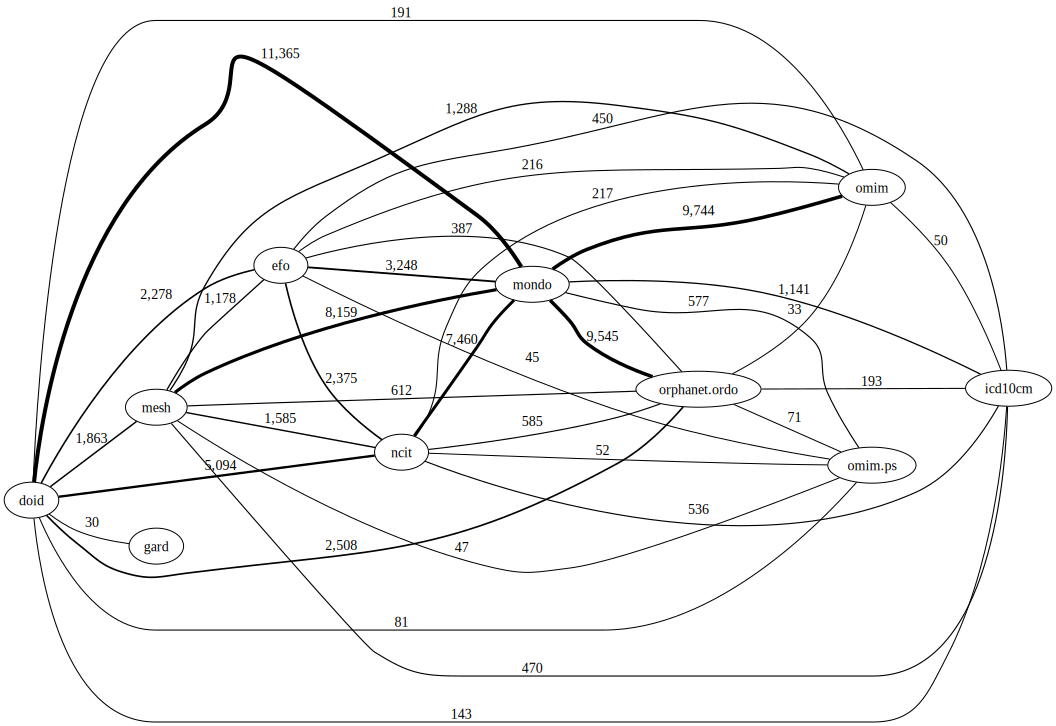

In [14]:
x = _graph_svg(symmetric_counts, cls=nx.Graph, cutoff=20)
with open("disease_graph.svg", "wb") as file:
    file.write(x)
SVG(x)

In [15]:
# intersect with the terms for each to make sure we're not keeping any mappings that are irrelevant

symmetric = {}
for (l, r), count in symmetric_counts.items():
    if terms[r] and terms[l]:
        denom = min(len(terms[r]), len(terms[l]))
    elif terms[r]:
        denom = len(terms[r])
    elif terms[l]:
        denom = len(terms[l])
    else:
        denom = 1
    symmetric[l, r] = count / denom

symmetric_df = _df(symmetric).fillna(0.0)

# clip since there might be some artifacts of mappings to terms that don't exist anymore
(symmetric_df * 100).round(4)

target_prefix,doid,mondo,efo,mesh,ncit,orphanet,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd10pcs,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,,,
doid,100.0000,98.7316,109.4140,59.7115,44.2533,0.0,21.7879,1.6593,0.7037,0.2606,0.4691,1.2423,0.0,0.0,0.0,0.0434,0.0087
mondo,98.7316,100.0000,156.0038,261.5064,37.1255,0.0,39.6075,40.4332,2.3943,0.0083,0.6397,4.7346,0.0,0.0,0.0,0.0083,0.0000
efo,109.4140,156.0038,100.0000,56.5802,114.0730,0.0,18.5879,10.3746,2.1614,0.0000,0.4323,21.6138,0.0,0.0,0.0,0.0000,0.0000
mesh,59.7115,261.5064,56.5802,100.0000,50.8013,0.0,19.6154,41.2821,1.5064,0.0321,0.2132,15.0641,0.0,0.0,0.0,0.0321,0.0000
ncit,44.2533,37.1255,114.0730,50.8013,100.0000,0.0,2.9113,1.0799,0.2588,0.0100,0.3838,2.6675,0.0,0.0,0.0,0.0050,0.0000
orphanet,0.0000,0.0000,0.0000,0.0000,0.0000,100.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000
orphanet.ordo,21.7879,39.6075,18.5879,19.6154,2.9113,0.0,100.0000,3300.0000,7100.0000,100.0000,0.0000,19300.0000,0.0,0.0,0.0,100.0000,0.0000
omim,1.6593,40.4332,10.3746,41.2821,1.0799,0.0,3300.0000,100.0000,400.0000,200.0000,0.0426,5000.0000,0.0,0.0,0.0,100.0000,0.0000
omim.ps,0.7037,2.3943,2.1614,1.5064,0.2588,0.0,7100.0000,400.0000,100.0000,100.0000,0.0000,1900.0000,0.0,0.0,0.0,100.0000,0.0000


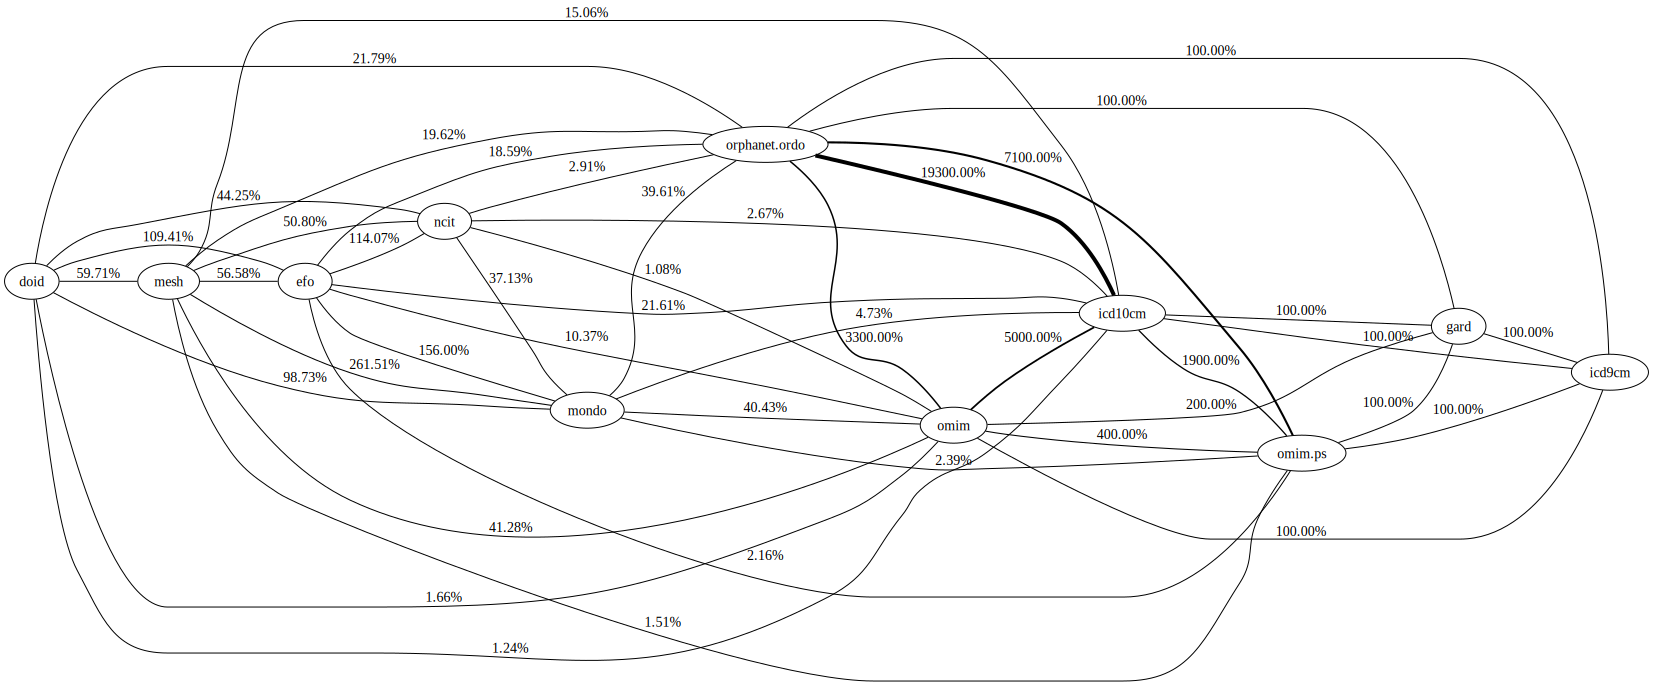

In [16]:
SVG(_graph_svg(symmetric, cls=nx.Graph, fmt=".2%", cutoff=0.01))

# Landscape Coverage

Before, we looked at the overlaps between each resource. Now, we use that information jointly to estimate the number of terms in the landscape itself, and estimate how much of the landscape each resource covers.

In [17]:
entities = defaultdict(set)
for mapping in mappings:
    for r in (mapping.s, mapping.o):
        entities[r.prefix].add(r.identifier)

counter = Counter()
graph = to_multidigraph(mappings)
for component in nx.weakly_connected_components(graph):
    prefixes = frozenset(r.prefix for r in component)
    counter[prefixes] += 1

at_least_1_mapping = sum(counter.values())

unique_to_single = defaultdict(set)
for prefix in CONFIGURATION.priority:
    prefix_terms = terms.get(prefix)
    if not prefix_terms:
        continue

    prefix_terms = set(prefix_terms)
    mapped_terms = entities[prefix]
    counter[frozenset([prefix])] = unique_to_single[prefix] = len(prefix_terms - mapped_terms)

only_1_mapping = sum(unique_to_single.values())
conserved = counter[frozenset(CONFIGURATION.priority)]
total_entity_estimate = sum(counter.values())

print(
    f"This estimates a total of {total_entity_estimate:,} unique entities.\n"
    f"Of these, {at_least_1_mapping:,} ({at_least_1_mapping/total_entity_estimate:.1%}) have at least one mapping.\n"
    f"{only_1_mapping:,} ({only_1_mapping/total_entity_estimate:.1%}) are unique to a single resource.\n"
    f"{conserved:,} ({conserved/total_entity_estimate:.1%}) appear in all {len(CONFIGURATION.priority)} resources.\n\n"
    "This estimate is susceptible to several caveats:\n\n"
    "- Missing mappings inflates this measurement\n"
    "- Generic resources like MeSH contain irrelevant entities that can't be mapped\n"
)

This estimates a total of 105,505 unique entities.
Of these, 16,866 (16.0%) have at least one mapping.
88,639 (84.0%) are unique to a single resource.
0 (0.0%) appear in all 17 resources.

This estimate is susceptible to several caveats:

- Missing mappings inflates this measurement
- Generic resources like MeSH contain irrelevant entities that can't be mapped



/var/folders/vp/n7_7v49n7dl7ln9bs8r0wbt80000gn/T/ipykernel_79635/1333214734.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


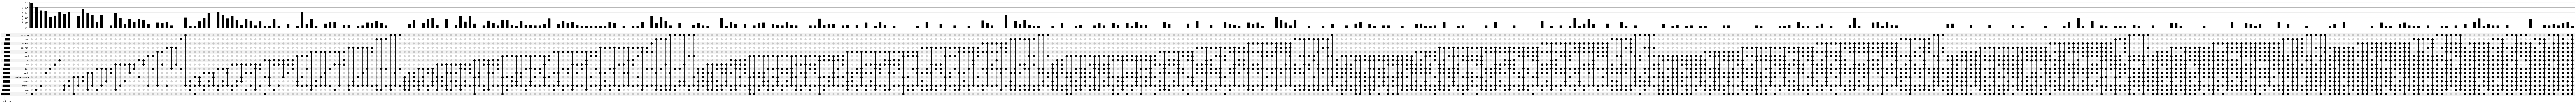

In [18]:
import upsetplot

example = upsetplot.from_memberships(*zip(*counter.most_common()))

"""Here's what the output from upsetplot.plot looks like:

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}
"""
plot_result = upsetplot.plot(
    example,
    # show_counts=True,
)
plot_result["intersections"].set_yscale("log")
plot_result["intersections"].set_ylim([1, plot_result["intersections"].get_ylim()[1]])
# plot_result["totals"].set_xlabel("Size")
mm, _ = plot_result["totals"].get_xlim()
plot_result["totals"].set_xlim([mm, 1])
plot_result["totals"].set_xscale("log")  # gets domain error

plt.tight_layout()
plt.savefig("disease_upset.svg")
plt.show()

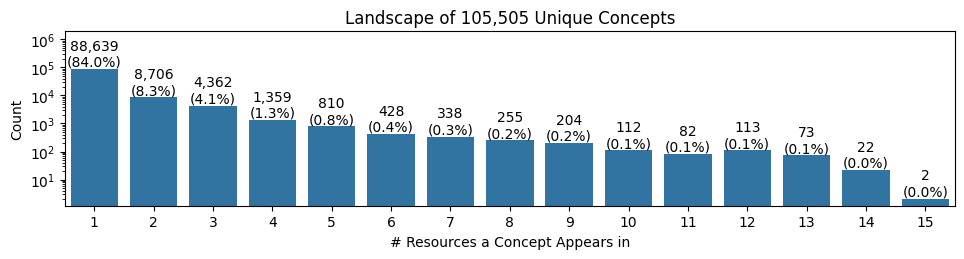

In [30]:
vv = Counter()
for k, v in counter.items():
    vv[len(k)] += v

max_value = max(vv.values())

fig, ax = plt.subplots(figsize=(len(vv) * 0.65, 2.7))
sns.barplot(vv, ax=ax)

for index, value in vv.items():
    plt.text(index - 1, value + 0.2, f"{value:,}\n({value/total_entity_estimate:.1%})", ha="center", va="bottom")

ax.set_xlabel("# Resources a Concept Appears in")
ax.set_ylabel("Count")
ax.set_title(f"Landscape of {total_entity_estimate:,} Unique Concepts")
ax.set_yscale("log")
a, b = ax.get_ylim()
# since we're in a log scale, pad half of the max value to the top to make sure
# the counts fit in the box
ax.set_ylim([a, b + 20 * max_value])
plt.tight_layout()
plt.savefig("disease_histogram.svg")
plt.show()